# Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Librerías de modelos
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline

# Librerías de búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold


# Importación de datos

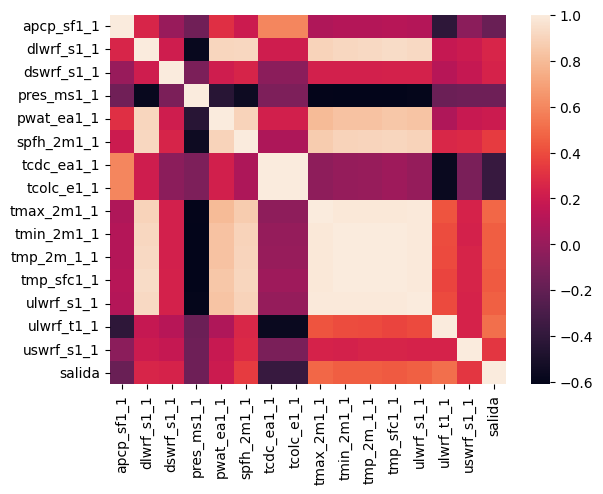

In [3]:
df = pd.read_csv("datos/disp_st2ns1.txt.bz2",
    compression="bz2",
    index_col=0)

disp_df = df.copy()

for field in disp_df:
    
    if field[-3] != "i" and int(field[-3]) != 1:
        disp_df.drop(field, axis=1, inplace=True)
        # ...
#make a correlation matrix of the dataframe and show it
corr = disp_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()


Podemos observar que las variables que mayor correlacción positiva presentan son aquellas correspondientes a la temperatura (tmax_2m1,...,tmp_sfc1) con la variable de ulwrf_t1.
corr negativa (pres_ms1 -> dlwrf_s1); (spfh_2m1 -> pres_ms1); (tmax_2m1-ulwrf_s1 -> pres_ms1); (ulwrf_t1 -> tcdc_ea1-tcolc_e1)

# Preparación de datos
## Train, test y validación

Dividimos los datos en los conjuntos de train y test. A su vez dividimos el conjunto de train para preparar las comparaciones entre los diferentes modelos.

In [4]:
train = df.iloc[:10*365]
test = df.iloc[10*365:]

train_train = train.iloc[:8*365]
train_validation = train.iloc[8*365:]

#separamos la variable objetivo en los sets de entrenamiento y validación
X_train_train = train_train.iloc[:, :75]
Y_train_train = train_train.iloc[:, 75]

X_train_validation = train_validation.iloc[:, :75]
Y_train_validation = train_validation.iloc[:, 75]


## Creación de un modelo dummy

In [5]:
#create a dummy regressor using the median to compare
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_train, Y_train_train)
dummy_pred = dummy.predict(X_train_validation)

dummy_mae = mean_absolute_error(Y_train_validation, dummy_pred)
print("dummy MAE: ",dummy_mae)

dummy_rmse = np.sqrt(mean_squared_error(Y_train_validation,dummy_pred))
print("dummy RMSE: ", dummy_rmse)

dummy MAE:  6720947.2602739725
dummy RMSE:  7809144.902737563


# Métodos Básicos
## Creación de modelos
Usamos KNeighborsRegressor 

In [6]:
reg = KNeighborsRegressor()

scaler = StandardScaler()
X_train_train_norm = scaler.fit_transform(X_train_train)
X_train_validation_norm = scaler.transform(X_train_validation)

scaler_y = StandardScaler()
Y_train_train_norm = scaler_y.fit_transform(Y_train_train.values.reshape(-1, 1)).ravel()
Y_train_validation_norm = scaler_y.transform(Y_train_validation.values.reshape(-1, 1)).ravel()
reg.fit(X_train_train_norm, Y_train_train_norm)
y_pred_norm = reg.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).ravel()


# reg.fit(X_train_train, Y_train_train)

# reg_pred = reg.predict(X_train_validation)

#compute Mean absolute error
reg_mae = mean_absolute_error(Y_train_validation, y_pred)
print("model MAE: ", reg_mae)


reg_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("model rmse: ", reg_rmse)


print("model score: ", reg.score(X_train_validation_norm, Y_train_validation_norm))

model MAE:  2536714.7671232875
model rmse:  3675153.3534838464
model score:  0.777642376391267


Procedemos a usar arboles de regresión

In [7]:
treeREG = DecisionTreeRegressor(random_state=2)
treeREG.fit(X_train_train, Y_train_train)
tree_pred = treeREG.predict(X_train_validation)

tree_mae = mean_absolute_error(Y_train_validation, tree_pred)
print("model MAE: ",tree_mae)

tree_rmse = np.sqrt(mean_squared_error(Y_train_validation, tree_pred))
print("model rmse: ",tree_rmse)


model MAE:  3344148.493150685
model rmse:  4829894.676721137


Usamos regresion lineal

In [8]:
Li_Reg = LinearRegression()
Li_Reg.fit(X_train_train, Y_train_train)
Li_pred = Li_Reg.predict(X_train_validation)

Li_mae = mean_absolute_error(Y_train_validation, Li_pred)
print("model MAE: ",Li_mae)

Li_rmse = np.sqrt(mean_squared_error(Y_train_validation, Li_pred))
print("model rmse: ",Li_rmse)

model MAE:  2265683.8029644317
model rmse:  3268115.4760422744


## Ajuste de hiperparámetros por búsqueda en cuadrícula

In [9]:
#pruebas varias
import sklearn
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'positive_likelihood_ratio', 'neg_negative_likelihood_ratio', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weig

KNeighborsRegressor

In [10]:
param_grid = {'n_neighbors': np.arange(1, 20), 'weights': ['uniform', 'distance'], 'p': [1, 2, 3, 4]}
grid = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
    refit='neg_mean_absolute_error',
    verbose=3,
    n_jobs=-1)

grid.fit(X_train_train_norm, Y_train_train_norm)

#print the best score throughout the grid search
print(grid.best_score_)
#print the best parameter used for the highest score of the model.
print(grid.best_params_)

Fitting 5 folds for each of 152 candidates, totalling 760 fits
[CV 1/5] END n_neighbors=1, p=1, weights=uniform; neg_mean_absolute_error: (test=-0.416) neg_mean_squared_error: (test=-0.350) total time=   0.2s
[CV 2/5] END n_neighbors=1, p=1, weights=uniform; neg_mean_absolute_error: (test=-0.403) neg_mean_squared_error: (test=-0.316) total time=   0.2s
[CV 3/5] END n_neighbors=1, p=1, weights=uniform; neg_mean_absolute_error: (test=-0.438) neg_mean_squared_error: (test=-0.393) total time=   0.2s[CV 2/5] END n_neighbors=1, p=2, weights=uniform; neg_mean_absolute_error: (test=-0.418) neg_mean_squared_error: (test=-0.346) total time=   0.1s

[CV 3/5] END n_neighbors=1, p=2, weights=uniform; neg_mean_absolute_error: (test=-0.454) neg_mean_squared_error: (test=-0.410) total time=   0.0s
[CV 5/5] END n_neighbors=1, p=1, weights=uniform; neg_mean_absolute_error: (test=-0.406) neg_mean_squared_error: (test=-0.343) total time=   0.2s
[CV 4/5] END n_neighbors=1, p=2, weights=uniform; neg_mean_ab

Evaluación del modelo

In [11]:
# entrenar modelo
mejor_modelo = KNeighborsRegressor(**grid.best_params_)
mejor_modelo.fit(X_train_train_norm, Y_train_train_norm)

y_pred = mejor_modelo.predict(X_train_validation_norm)

# Evaluacion
print("model score: ", mejor_modelo.score(X_train_validation_norm, Y_train_validation_norm))

model score:  0.7940187422020105


Árboles de regresión

In [12]:

# Search space
param_grid = {
    'max_depth': range(2, 16, 2),
    'min_samples_split': range(2, 16, 2)
}

# 3-Fold cross validation for the inner loop.
inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Definition of a 2-step process that self-adjusts 2 hyperparams
grid = GridSearchCV(estimator=DecisionTreeRegressor(random_state=2),
                    param_grid=param_grid,
                    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
                    refit='neg_mean_absolute_error',
                    cv=inner, 
                    n_jobs=1,
                    verbose=3)

grid.fit(X_train_train, Y_train_train)

#print the best score throughout the grid search
print(grid.best_score_)
#print the best parameter used for the highest score of the model.
print(grid.best_params_)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV 1/3] END max_depth=2, min_samples_split=2; neg_mean_absolute_error: (test=-3212506.872) neg_mean_squared_error: (test=-18059187546806.449) total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=2; neg_mean_absolute_error: (test=-3281765.249) neg_mean_squared_error: (test=-18277726057453.273) total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=2; neg_mean_absolute_error: (test=-3347544.442) neg_mean_squared_error: (test=-20100450567010.918) total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_split=4; neg_mean_absolute_error: (test=-3212506.872) neg_mean_squared_error: (test=-18059187546806.449) total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=4; neg_mean_absolute_error: (test=-3281765.249) neg_mean_squared_error: (test=-18277726057453.273) total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=4; neg_mean_absolute_error: (test=-3347544.442) neg_mean_squared_error: (test=-20100

Evaluación del modelo

In [13]:
# entrenar modelo
mejor_modelo = DecisionTreeRegressor(**grid.best_params_)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)

# Evaluacion
print("model score: ", mejor_modelo.score(X_train_validation, Y_train_validation))

model score:  0.7524640455667042


Regresión lineal

In [14]:
param_grid ={
    #hiperparametros para regresion lineal
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
    
}

grid = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
    refit='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=3)

grid.fit(X_train_train, Y_train_train)

#print the best score throughout the grid search
print(grid.best_score_)
#print the best parameter used for the highest score of the model.
print(grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END copy_X=True, fit_intercept=True, positive=True; neg_mean_absolute_error: (test=-2900203.899) neg_mean_squared_error: (test=-15749786656526.018) total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, positive=True; neg_mean_absolute_error: (test=-3100075.066) neg_mean_squared_error: (test=-15640267161115.771) total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, positive=True; neg_mean_absolute_error: (test=-2804776.395) neg_mean_squared_error: (test=-13749904099895.227) total time=   0.0s
[CV 1/5] END copy_X=True, fit_intercept=True, positive=False; neg_mean_absolute_error: (test=-2554290.292) neg_mean_squared_error: (test=-13315557672957.637) total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, positive=False; neg_mean_absolute_error: (test=-2468947.277) neg_mean_squared_error: (test=-11391105055840.408) total time=   0.0s
[CV 4/5] END copy_X=True, fit_intercept=True, positive=Fal

Evaluación del modelo

In [15]:
# entrenar modelo
mejor_modelo = LinearRegression(**grid.best_params_)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)

# Evaluacion
print("model score: ", mejor_modelo.score(X_train_validation, Y_train_validation))

model score:  0.8241688243984733


El modelo con mayor score es el de regresión lineal, por lo que procedemos a usarlo para predecir los valores de la variable de test.

# Métodos Avanzados
## Creación de modelos

SVM

In [16]:

svm = SVR()
scaler = StandardScaler()

X_train_train_norm = scaler.fit_transform(X_train_train)
X_train_validation_norm = scaler.transform(X_train_validation)

scaler_y = StandardScaler()
Y_train_train_norm = scaler_y.fit_transform(Y_train_train.values.reshape(-1, 1)).ravel()
Y_train_validation_norm = scaler_y.transform(Y_train_validation.values.reshape(-1, 1)).ravel()
svm.fit(X_train_train_norm, Y_train_train_norm)
y_pred_norm = svm.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).ravel()

#pip_svm = Pipeline([('scaler', scaler), ('svm', svm)])

# pip_svm.fit(X_train_train, Y_train_train)
# svm_pred = pip_svm.predict(X_train_validation)

svm_mae = mean_absolute_error(Y_train_validation, y_pred)
print("model MAE: ",svm_mae)

svm_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("model rmse: ", svm_rmse)

print("model score: ", svm.score(X_train_validation_norm, Y_train_validation_norm))

model MAE:  2224652.794901519
model rmse:  3353514.55860678
model score:  0.8148594775863227


Random Forest

In [17]:
rfr = RandomForestRegressor(random_state=2)
rfr.fit(X_train_train, Y_train_train)
rfr_pred = rfr.predict(X_train_validation)

rfr_mae = mean_absolute_error(Y_train_validation, rfr_pred)
print("model MAE: ",rfr_mae)

rfr_rmse = np.sqrt(mean_squared_error(Y_train_validation, rfr_pred))
print("model rmse: ", rfr_rmse)

print("model score: ", rfr.score(X_train_validation, Y_train_validation))

model MAE:  2278659.197260274
model rmse:  3341026.470443267
model score:  0.8162357926282553


## Ajuste de hiperparámetros por búsqueda en cuadrícula
SVM

In [18]:
pipe_svr = Pipeline([('scale', scaler), ('SVM', svm)])

np.random.seed(42)
pipe_svr.fit(X_train_train, Y_train_train)



param_grid ={
    # 'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'SVM__C' : [0.1, 1, 10, 100],
    'SVM__gamma': [0.01, 0.1, 1],    
}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    # estimator=SVR(),
    pipe_svr,
    param_grid=param_grid,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
    refit='neg_mean_absolute_error',
    cv=inner,
    n_jobs=4,
    verbose=1)

np.random.seed(42)
grid.fit(X_train_train_norm, Y_train_train_norm)

#print the best score throughout the grid search
print(grid.best_score_)
#print the best parameter used for the highest score of the model.
print(grid.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
-0.28019596865005186
{'SVM__C': 1, 'SVM__gamma': 0.01}


Evaluación del modelo

In [19]:
# entrenar modelo    
mejor_modelo = SVR(
    C= grid.best_params_['SVM__C'],
    gamma= grid.best_params_['SVM__gamma'],
    ) 
mejor_modelo.fit(X_train_train_norm, Y_train_train_norm)

y_pred = mejor_modelo.predict(X_train_validation_norm)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

# Evaluacion
svm_mae = mean_absolute_error(Y_train_validation, y_pred)
print("model MAE: ", svm_mae)

svm_rmse = np.sqrt(mean_squared_error(Y_train_validation, y_pred))
print("model rmse: ", svm_rmse)

print("model score: ", mejor_modelo.score(X_train_validation_norm, Y_train_validation_norm))

model MAE:  2207095.858102191
model rmse:  3341132.405893116
model score:  0.8162241390524618


Random Forest

In [21]:
param_grid ={
    'n_estimators': [10, 100, 1000, 10000],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=2),
    param_grid=param_grid,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'], 
    refit='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=3)

grid.fit(X_train_train, Y_train_train)

#print the best score throughout the grid search
print(grid.best_score_)
#print the best parameter used for the highest score of the model.
print(grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_features=sqrt, n_estimators=10; neg_mean_absolute_error: (test=-2603178.390) neg_mean_squared_error: (test=-14162503836094.521) total time=   0.2s
[CV 3/5] END max_features=sqrt, n_estimators=10; neg_mean_absolute_error: (test=-2911387.860) neg_mean_squared_error: (test=-15451031702710.787) total time=   0.2s
[CV 2/5] END max_features=sqrt, n_estimators=10; neg_mean_absolute_error: (test=-2481154.212) neg_mean_squared_error: (test=-12282147922536.986) total time=   0.2s
[CV 5/5] END max_features=sqrt, n_estimators=10; neg_mean_absolute_error: (test=-2338858.613) neg_mean_squared_error: (test=-11706736702889.896) total time=   0.2s
[CV 4/5] END max_features=sqrt, n_estimators=10; neg_mean_absolute_error: (test=-2274693.339) neg_mean_squared_error: (test=-10940198134464.555) total time=   0.2s
[CV 1/5] END max_features=sqrt, n_estimators=100; neg_mean_absolute_error: (test=-2439819.786) neg_mean_squared_error: (

Evaluación del modelo

In [ ]:
# entrenar modelo
mejor_modelo = RandomForestRegressor(**grid.best_params_)
mejor_modelo.fit(X_train_train, Y_train_train)

y_pred = mejor_modelo.predict(X_train_validation)

# Evaluacion
print("model score: ", mejor_modelo.score(X_train_validation, Y_train_validation))